# Investigate Training Performance

We want to make sure the GAN not just memorizes the training data but learns the true properties of the data.

In [1]:
import arpes
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline

In [2]:
mapFolder, edcStack, trimEDCs = arpes.loadAllData()
shortEDCs = np.array([trimEDCs[i][250:500] for i in range(trimEDCs.shape[0])])

# Normalize and shift the intensity:
scaleEDCs = np.array([arpes.scaleEDC(shortEDCs[i]) for i in range(shortEDCs.shape[0])])
ssEDCs = np.array([arpes.scaleAndShiftEDC(shortEDCs[i]) for i in range(shortEDCs.shape[0])])

Number of raw map = 21
total data point = 428
trimEDCs.shape = (428, 1693)


## LSGAN

In [3]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, Adadelta, SGD

Using TensorFlow backend.


In [124]:
class LSGAN():
    def __init__(self, opt, loss, info=False):
        self.n_pixel = 250
        self.data_shape = (self.n_pixel,)
        self.opt = opt

        optimizer_map = {'adam':Adam(0.0003, 0.5), 'adadelta':Adadelta(lr=1.0), 'sgd':SGD(lr=0.003)}
        optimizer = optimizer_map[opt]

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator(info)
        self.discriminator.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

        # Build the generator: 
        # info=True will show the structure of generator
        self.generator = self.build_generator(info)

        # The generator takes a latent variable z and generates a 1D vector
        z = Input(shape=(100,))
        f_datum = self.generator(z)

        # We will only train the generator:
        self.discriminator.trainable = False

        # The validate takes generated data as input and determines validity from the discriminator
        validate = self.discriminator(f_datum)

        # The combined model  (stacked generator and discriminator) takes
        # z as input => generates fake data => determines validity
        self.combined = Model(z, validate)
        self.combined.compile(loss=loss, optimizer=optimizer)

    def build_generator(self, info=False):

        noise_shape = (100,) # for latent variable z

        model = Sequential()

        # Create three layers with activation LeakyReLU:
        model.add(Dense(1024, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.data_shape), activation='tanh'))
        model.add(Reshape(self.data_shape))

        if info:
            model.summary()

        noise = Input(shape=noise_shape)
        f_datum = model(noise) # This is fake data: g(z)

        return Model(noise, f_datum)

    def build_discriminator(self, info=False):
        data_shape = (self.n_pixel, )

        model = Sequential()

        model.add(Dense(512, input_shape=data_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1))
        
        if info:
            # print summary of discriminator:
            model.summary()

        datum = Input(shape=data_shape)
        validity = model(datum)

        return Model(datum, validity)

    def train(self, X_train, epochs, batch_size=100, sample_interval=100):
        
        X_train = X_train
        self.batch_size = batch_size
        self.epochs = epochs

        half_batch = int(batch_size / 2)

        self.d_loss = np.zeros(epochs)
        self.g_loss = np.zeros(epochs)
        self.d_acc = np.zeros(epochs)
        for epoch in range(epochs):

            ##### TRAIN DISCRIMINATOR #####

            # Select a random half batch of data
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            data = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new data
            fake_data = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(data, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(fake_data, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            self.d_loss[epoch] = d_loss[0]
            self.d_acc[epoch] = d_loss[1]
            

            ##### TRAIN GENERATOR #####

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples as valid (ones)
            valid_y = np.array([1] * batch_size)

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)
            self.g_loss[epoch] = g_loss

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                # Plot the progress
                self.sample_images(epoch)
                if epoch % (4*sample_interval) == 0:
                    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                

    def sample_images(self, epoch):
        r, c = 2, 2
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].plot(gen_imgs[cnt])
                cnt += 1
        # fig.savefig("images_{}/batch{}/arpes_{}.png".format(self.opt, self.batch, epoch))
        # fig.savefig("images_{}/epoch{}/arpes_{}.png".format(self.opt, self.epochs, epoch))
        plt.close()

        
    def create_fake_data(self, n):
        noise = np.random.normal(0, 1, (n, 100))
        fake_data = self.generator.predict(noise)
        return fake_data
    
        
def plotGANprocess(gan, stepsize):
    x = np.arange(0, len(gan.d_acc), stepsize)
    y = np.array([np.mean(gan.d_acc[i*stepsize:(i+1)*stepsize]) for i in range(len(x))])
    plt.figure(figsize=[11, 4])
    plt.subplot(1,2,1)
    plt.plot(x, gan.d_acc[::stepsize], label="ith")
    plt.plot(x, y, label='mean')
    plt.axhline(y=.5, c='r', ls='--')
    plt.xlabel('epoch', fontsize=13)
    plt.ylabel('Discrimiator Accuracy', fontsize=12)
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(x, gan.d_loss[::stepsize], label='Discriminator', c=(0.25, 0.65, 0.4))
    plt.plot(x, gan.g_loss[::stepsize], label='Generator', c=(0.7, 0.3, 0.5))
    plt.xlabel('epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=11)
    plt.show()

### Choose Adadelta Optimizer + LeakyReLU Activation + MSE Loss + Batch_size 20

In [ ]:
gan = LSGAN('adadelta', 'mse', False)   
gan.train(ssEDCs, epochs=15000, batch_size=20, sample_interval=500)
plotGANprocess(gan, 100)

## Dimension Reduction: PCA

In [5]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)

# np.random.seed(42)

In [7]:
# Three components:
X = ssEDCs.copy()
pca = PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)

In [8]:
trace = go.Scatter3d(x=X[:, 0], y=X[:, 1], z=X[:, 2], 
                      mode='markers', marker=dict(size=3))
data = [trace]
layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))
py.iplot(go.Figure(data=data, layout=layout))

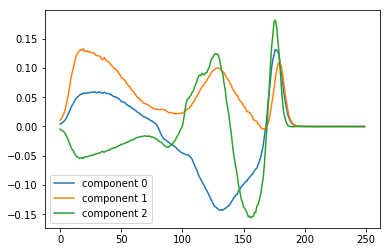

In [10]:
comp = pca.components_
# reconX = np.dot(X,comp)

plt.figure()
for c in range(3):
    plt.plot(comp[c], label='component '+str(c))
plt.legend()
plt.show()

In [17]:
# Find out outlier data:
def inSmallerGroup(x):
    return x[0]>1 and x[1]>0.5 and x[2]<0.5

def inBiggerGroup(x):
    return not inSmallerGroup(x)

In [18]:
group2 = X[[inSmallerGroup(X[i]) for i in range(X.shape[0])]]
group1 = X[[inBiggerGroup(X[i]) for i in range(X.shape[0])]]

In [20]:
trace1 = go.Scatter3d(x=group1[:, 0], y=group1[:, 1], z=group1[:, 2], mode='markers', marker=dict(size=3))
trace2 = go.Scatter3d(x=group2[:, 0], y=group2[:, 1], z=group2[:, 2], mode='markers', marker=dict(size=3))

data = [trace1, trace2]
layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))
py.iplot(go.Figure(data=data, layout=layout))

### Look into the outliers:

In [24]:
recon1 = np.dot(group1,comp)
recon2 = np.dot(group2,comp)

origin1 = ssEDCs[[inBiggerGroup(X[i]) for i in range(X.shape[0])]]
origin2 = ssEDCs[[inSmallerGroup(X[i]) for i in range(X.shape[0])]]

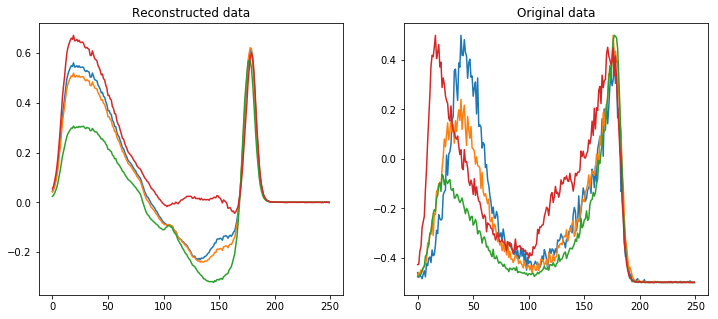

In [26]:
plt.figure(figsize=[12, 5])
plt.subplot(1,2,1)
plt.plot(recon2[0])
plt.plot(recon2[5])
plt.plot(recon2[10])
plt.plot(recon2[20])
plt.title("Reconstructed data")
plt.subplot(1,2,2)
plt.plot(origin2[0])
plt.plot(origin2[5])
plt.plot(origin2[10])
plt.plot(origin2[20])
plt.title("Original data")
plt.show()

## Validation

### 1. Train-Test Split:

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
# Train-test split:
X_real = ssEDCs.copy()
X_train, X_test = train_test_split(X_real, test_size=0.25, shuffle=True)

### 2. Train GAN with training data:

C:\Users\Elite840G2\Anaconda3\envs\ds100\lib\site-packages\keras\engine\training.py:973: UserWarning:

Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?



0 [D loss: 0.996500, acc.: 50.00%] [G loss: 1.362045]
2000 [D loss: 0.291420, acc.: 40.00%] [G loss: 0.631453]
4000 [D loss: 0.271458, acc.: 40.00%] [G loss: 0.399385]
6000 [D loss: 0.202409, acc.: 70.00%] [G loss: 0.387370]
8000 [D loss: 0.172313, acc.: 70.00%] [G loss: 0.449300]
10000 [D loss: 0.305061, acc.: 45.00%] [G loss: 0.368987]
12000 [D loss: 0.265429, acc.: 50.00%] [G loss: 0.384806]
14000 [D loss: 0.243541, acc.: 55.00%] [G loss: 0.341944]
16000 [D loss: 0.253120, acc.: 50.00%] [G loss: 0.377456]
18000 [D loss: 0.213279, acc.: 65.00%] [G loss: 0.355550]
20000 [D loss: 0.240421, acc.: 55.00%] [G loss: 0.364318]
22000 [D loss: 0.305057, acc.: 45.00%] [G loss: 0.336738]
24000 [D loss: 0.210842, acc.: 65.00%] [G loss: 0.338574]


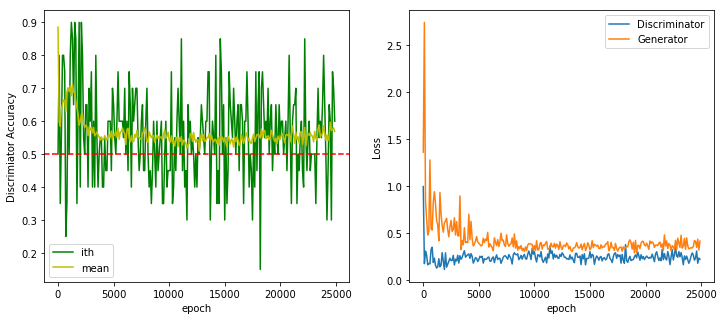

Wall time: 13min 16s


In [39]:
gan = LSGAN('adadelta', 'mse', False)   
gan.train(X_train, epochs=20000, batch_size=20, sample_interval=500)
plotGANprocess(gan, 100)

### 3. Creat Fake Data with GAN:

In [52]:
# Create 107 fake data (same size as test data set)
fake_n = X_test.shape[0]
noise = np.random.normal(0, 1, (fake_n, 100))
fake_data = gan.generator.predict(noise)

### 4. PCA:

In [53]:
pca = PCA(n_components=3)
pca.fit(X_train)
pca_fake = PCA(n_components=3)
pca_fake.fit(fake_data)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

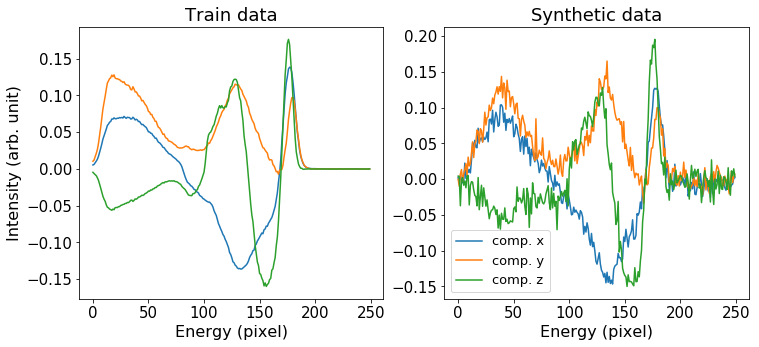

In [149]:
comp = pca.components_
comp_fake = pca_fake.components_
# reconX = np.dot(X,comp)
comp_str = ['x', 'y', 'z']

plt.figure(figsize=[12, 5])
plt.subplot(1,2,1)
for c in range(3):
    plt.plot(comp[c], label='component '+comp_str[c])
# plt.legend()
plt.ylabel('Intensity (arb. unit)', fontsize=16)
plt.xlabel('Energy (pixel)', fontsize=16)
plt.title("Train data", fontsize=18)
plt.tick_params(axis='both', labelsize=15)
plt.subplot(1,2,2)
for c in range(3):
    plt.plot(comp_fake[c], label='comp. '+comp_str[c])
plt.legend(fontsize=13)
plt.xlabel('Energy (pixel)', fontsize=16)
plt.title("Synthetic data", fontsize=18)
plt.tick_params(axis='both', labelsize=15)
plt.savefig("PCA_components.png")

In [129]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
X_fake_pca = pca.transform(fake_data)

trace1 = go.Scatter3d(x=X_train_pca[:, 0], y=X_train_pca[:, 1], z=X_train_pca[:, 2], 
                      mode='markers', marker=dict(size=3), name='train')
trace2 = go.Scatter3d(x=X_test_pca[:, 0], y=X_test_pca[:, 1], z=X_test_pca[:, 2], 
                      mode='markers', marker=dict(size=3), name='test')
trace3 = go.Scatter3d(x=X_fake_pca[:, 0], y=X_fake_pca[:, 1], z=X_fake_pca[:, 2], 
                      mode='markers', marker=dict(size=3), name='synthetic')
data = [trace1, trace2, trace3]
layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))
py.iplot(go.Figure(data=data, layout=layout))

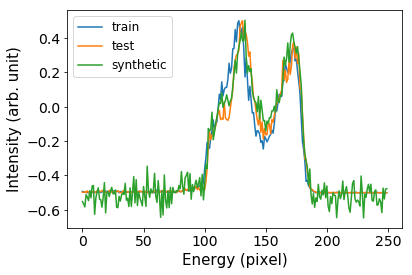

In [141]:
plt.figure()
plt.plot(X_train[197], label='train')
plt.plot(X_test[46], label='test')
plt.plot(fake_data[71], label='synthetic')
plt.legend(fontsize=12)
plt.xlabel("Energy (pixel)", fontsize=15)
plt.ylabel("Intensity (arb. unit)", fontsize=15)
plt.tick_params(axis='both', labelsize=14)
plt.show()

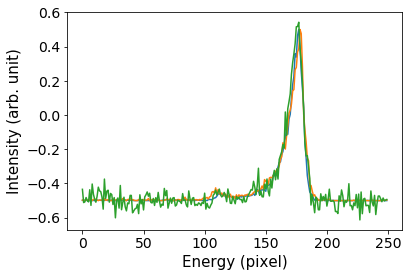

In [140]:
plt.figure()
plt.plot(X_train[143], label='train')
plt.plot(X_test[92], label='test')
plt.plot(fake_data[103], label='synthetic')
# plt.legend()
plt.xlabel("Energy (pixel)", fontsize=15)
plt.ylabel("Intensity (arb. unit)", fontsize=15)
plt.tick_params(axis='both', labelsize=14)
plt.show()

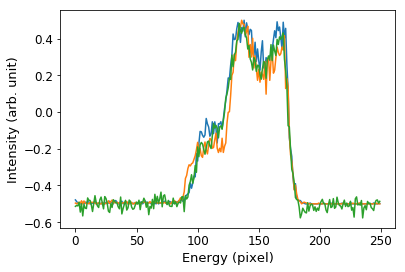

In [135]:
plt.figure()
plt.plot(X_train[57], label='train')
plt.plot(X_test[39], label='test')
plt.plot(fake_data[27], label='synthetic')
# plt.legend()
plt.xlabel("Energy (pixel)", fontsize=13)
plt.ylabel("Intensity (arb. unit)", fontsize=13)
plt.tick_params(axis='both', labelsize=12)
plt.show()

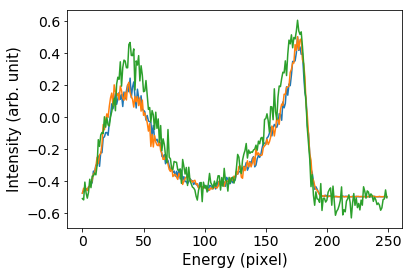

In [142]:
plt.figure()
plt.plot(X_train[98], label='train')
plt.plot(X_test[16], label='test')
plt.plot(fake_data[5], label='synthetic')
plt.xlabel("Energy (pixel)", fontsize=15)
plt.ylabel("Intensity (arb. unit)", fontsize=15)
plt.tick_params(axis='both', labelsize=14)
plt.show()

In [96]:
np.where(np.round(X_fake_pca, 3) == [3.489, 3.006, -.635])

(array([5, 5, 5], dtype=int64), array([0, 1, 2], dtype=int64))

In [94]:
np.where(np.round(X_train_pca, 3) == [3.366, 2.125, -0.221])

(array([ 98,  98,  98, 161], dtype=int64), array([0, 1, 2, 0], dtype=int64))

In [95]:
np.where(np.round(X_test_pca, 3) == [3.441, 2.225, -0.208])

(array([16, 16, 16], dtype=int64), array([0, 1, 2], dtype=int64))

## Measure Distance

Try to measure the distance between each synthetic data and its nearest neighbor from the training and testing data.

In [171]:
def distance(x1, x2):
    return np.linalg.norm(x1-x2)

def train_test_fake_distance(Xtrain, Xtest, Xfake):
    nearest_dist_train = np.array([np.min([distance(Xtrain[i], Xfake[j]) for i in range(Xtrain[0].shape[0])]) for j in range(Xfake.shape[0])])
    nearest_dist_test = np.array([np.min([distance(Xtest[i], Xfake[j]) for i in range(Xtest[0].shape[0])]) for j in range(Xfake.shape[0])])
    return nearest_dist_train, nearest_dist_test

def show_dist_distribution(nearest_dist_train, nearest_dist_test, title, b=30):
    print("Train: mean={}, std={}".format(np.mean(nearest_dist_train), np.std(nearest_dist_train)))
    print("Test: mean={}, std={}".format(np.mean(nearest_dist_test), np.std(nearest_dist_test)))

    bins_train = np.linspace(min(nearest_dist_train), max(nearest_dist_train), b)
    bins_test = np.linspace(min(nearest_dist_test), max(nearest_dist_test), b)

    plt.figure(figsize=[6, 4.2])
    plt.hist(nearest_dist_train, bins_train, alpha=0.5, label='dist_to_train')
    plt.hist(nearest_dist_test, bins_test, alpha=0.5, label='dist_to_test')
    plt.tick_params(axis='both', labelsize=14)
    plt.legend(fontsize=14)
    plt.xlabel("distance", fontsize=16)
    plt.title(title, fontsize=16)
    plt.savefig('synthetic_dist.png')
    plt.show()

In [56]:
nearest_dist_train, nearest_dist_test = train_test_fake_distance(X_train_pca, X_test_pca, X_fake_pca)

Train: mean=1.693002675574737, std=1.3220321683523495
Test: mean=1.2155646032842762, std=1.1690788755624164


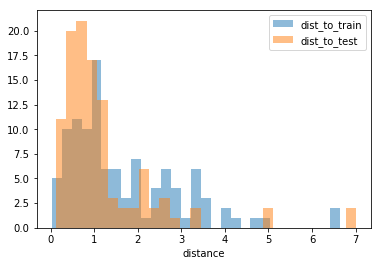

In [57]:
show_dist_distribution(nearest_dist_train, nearest_dist_test, "")

## Cross Validation: epoch

Same as the previous analysis, but we want to check if iterating too many times while training the model will lead to overfitting:

C:\Users\Elite840G2\Anaconda3\envs\ds100\lib\site-packages\keras\engine\training.py:973: UserWarning:

Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?



0 [D loss: 0.206368, acc.: 60.00%] [G loss: 0.886345]
2000 [D loss: 0.222887, acc.: 50.00%] [G loss: 0.469685]
4000 [D loss: 0.236639, acc.: 50.00%] [G loss: 0.498308]
6000 [D loss: 0.238509, acc.: 50.00%] [G loss: 0.423273]


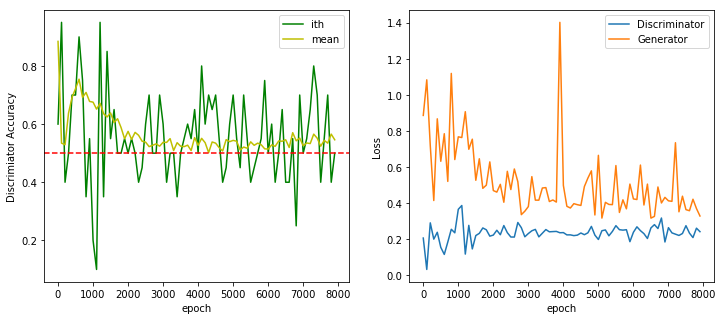

0 [D loss: 0.642944, acc.: 50.00%] [G loss: 1.300389]
2000 [D loss: 0.150527, acc.: 80.00%] [G loss: 0.405559]
4000 [D loss: 0.216659, acc.: 65.00%] [G loss: 0.428490]
6000 [D loss: 0.251075, acc.: 35.00%] [G loss: 0.438891]
8000 [D loss: 0.223062, acc.: 65.00%] [G loss: 0.401922]
10000 [D loss: 0.235947, acc.: 50.00%] [G loss: 0.388725]
12000 [D loss: 0.359414, acc.: 45.00%] [G loss: 0.371689]


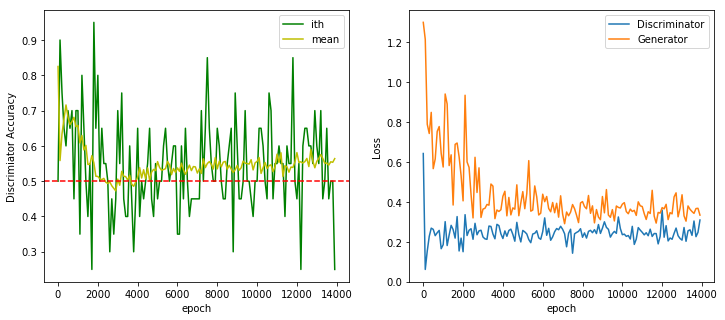

0 [D loss: 0.951249, acc.: 50.00%] [G loss: 0.858225]
2000 [D loss: 0.198724, acc.: 60.00%] [G loss: 0.493122]
4000 [D loss: 0.293179, acc.: 35.00%] [G loss: 0.498688]
6000 [D loss: 0.201339, acc.: 70.00%] [G loss: 0.359208]
8000 [D loss: 0.303618, acc.: 35.00%] [G loss: 0.322409]
10000 [D loss: 0.265954, acc.: 50.00%] [G loss: 0.332741]
12000 [D loss: 0.243708, acc.: 45.00%] [G loss: 0.328930]
14000 [D loss: 0.245731, acc.: 45.00%] [G loss: 0.359322]
16000 [D loss: 0.194114, acc.: 65.00%] [G loss: 0.305662]
18000 [D loss: 0.278041, acc.: 50.00%] [G loss: 0.350879]


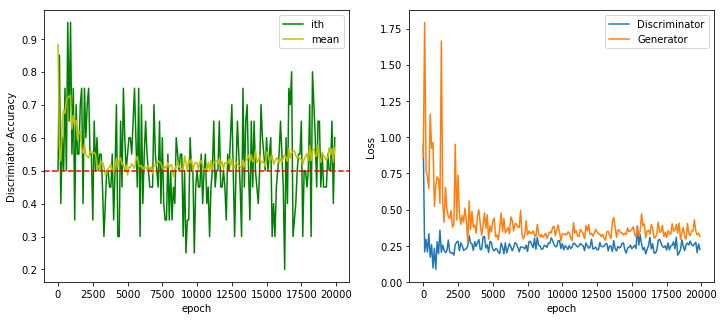

0 [D loss: 0.522637, acc.: 50.00%] [G loss: 1.207943]
2000 [D loss: 0.245227, acc.: 55.00%] [G loss: 0.426541]
4000 [D loss: 0.241824, acc.: 55.00%] [G loss: 0.311986]
6000 [D loss: 0.217626, acc.: 65.00%] [G loss: 0.546900]
8000 [D loss: 0.240081, acc.: 70.00%] [G loss: 0.375574]
10000 [D loss: 0.284368, acc.: 40.00%] [G loss: 0.324865]
12000 [D loss: 0.212372, acc.: 70.00%] [G loss: 0.300864]
14000 [D loss: 0.249542, acc.: 50.00%] [G loss: 0.361387]
16000 [D loss: 0.226924, acc.: 70.00%] [G loss: 0.397111]
18000 [D loss: 0.257523, acc.: 55.00%] [G loss: 0.331262]
20000 [D loss: 0.194669, acc.: 70.00%] [G loss: 0.366259]
22000 [D loss: 0.232673, acc.: 50.00%] [G loss: 0.460166]
24000 [D loss: 0.244161, acc.: 50.00%] [G loss: 0.416707]


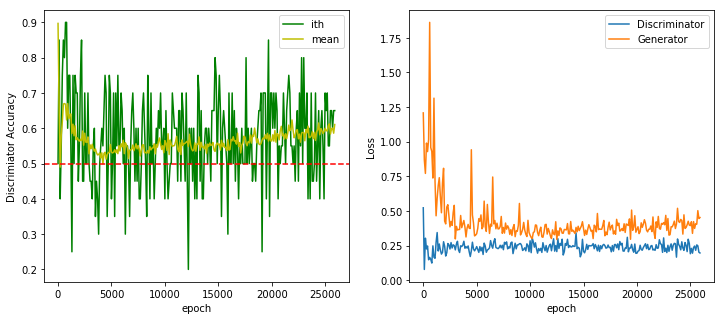

0 [D loss: 0.203640, acc.: 50.00%] [G loss: 0.633885]
2000 [D loss: 0.226288, acc.: 45.00%] [G loss: 0.442411]
4000 [D loss: 0.268059, acc.: 60.00%] [G loss: 0.559521]
6000 [D loss: 0.255837, acc.: 55.00%] [G loss: 0.358846]
8000 [D loss: 0.253894, acc.: 45.00%] [G loss: 0.307258]
10000 [D loss: 0.209090, acc.: 65.00%] [G loss: 0.346168]
12000 [D loss: 0.223181, acc.: 65.00%] [G loss: 0.342959]
14000 [D loss: 0.291843, acc.: 40.00%] [G loss: 0.357088]
16000 [D loss: 0.193452, acc.: 60.00%] [G loss: 0.295470]
18000 [D loss: 0.193510, acc.: 75.00%] [G loss: 0.479435]
20000 [D loss: 0.217889, acc.: 65.00%] [G loss: 0.441040]
22000 [D loss: 0.226513, acc.: 75.00%] [G loss: 0.449745]
24000 [D loss: 0.253835, acc.: 50.00%] [G loss: 0.392300]
26000 [D loss: 0.222528, acc.: 50.00%] [G loss: 0.439426]
28000 [D loss: 0.203443, acc.: 75.00%] [G loss: 0.400951]
30000 [D loss: 0.244801, acc.: 60.00%] [G loss: 0.419619]


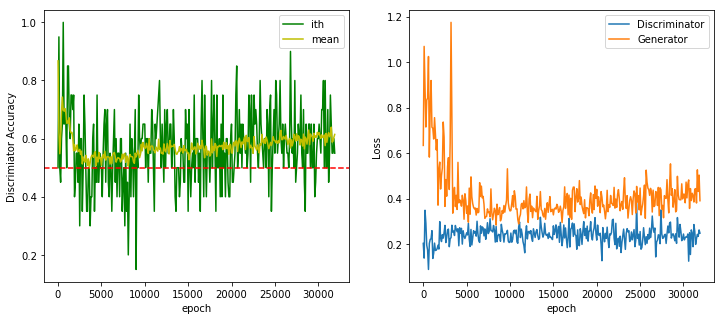

0 [D loss: 1.019479, acc.: 50.00%] [G loss: 1.471115]
2000 [D loss: 0.195589, acc.: 70.00%] [G loss: 0.672781]
4000 [D loss: 0.256671, acc.: 45.00%] [G loss: 0.336294]
6000 [D loss: 0.250242, acc.: 60.00%] [G loss: 0.345603]


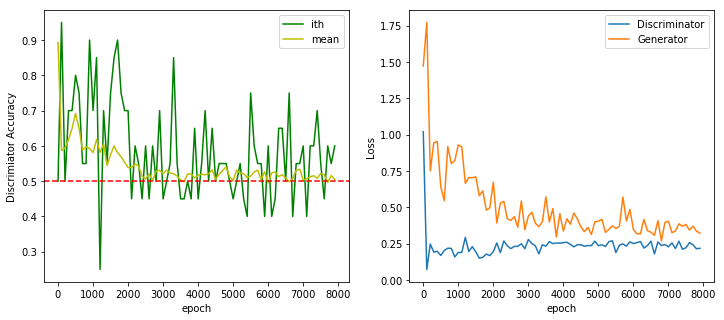

0 [D loss: 0.590361, acc.: 50.00%] [G loss: 1.192356]
2000 [D loss: 0.242712, acc.: 50.00%] [G loss: 0.411199]
4000 [D loss: 0.265847, acc.: 25.00%] [G loss: 0.498382]
6000 [D loss: 0.222402, acc.: 55.00%] [G loss: 0.372798]
8000 [D loss: 0.247785, acc.: 40.00%] [G loss: 0.371982]
10000 [D loss: 0.277558, acc.: 45.00%] [G loss: 0.333807]
12000 [D loss: 0.272765, acc.: 45.00%] [G loss: 0.361781]


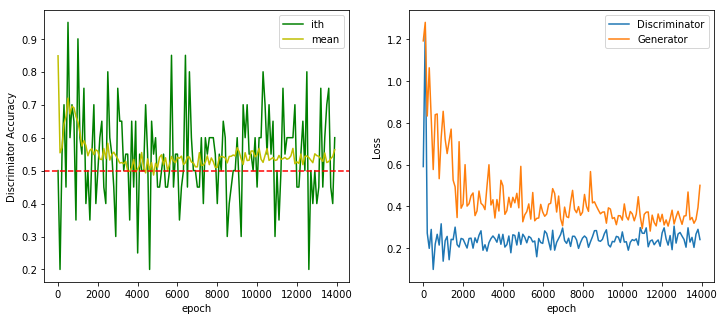

0 [D loss: 0.440779, acc.: 50.00%] [G loss: 0.486803]
2000 [D loss: 0.194542, acc.: 75.00%] [G loss: 0.465111]
4000 [D loss: 0.244653, acc.: 55.00%] [G loss: 0.369669]
6000 [D loss: 0.247864, acc.: 55.00%] [G loss: 0.410906]
8000 [D loss: 0.228926, acc.: 40.00%] [G loss: 0.358644]
10000 [D loss: 0.257936, acc.: 55.00%] [G loss: 0.369215]
12000 [D loss: 0.246983, acc.: 45.00%] [G loss: 0.333439]
14000 [D loss: 0.215937, acc.: 70.00%] [G loss: 0.334382]
16000 [D loss: 0.203750, acc.: 60.00%] [G loss: 0.321807]
18000 [D loss: 0.212950, acc.: 55.00%] [G loss: 0.335718]


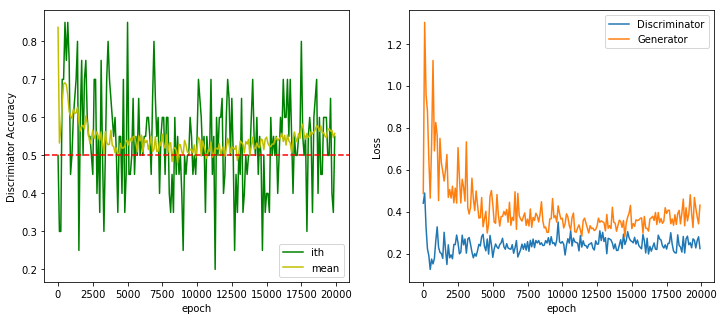

0 [D loss: 0.744981, acc.: 50.00%] [G loss: 0.904211]
2000 [D loss: 0.203359, acc.: 75.00%] [G loss: 0.950511]
4000 [D loss: 0.266337, acc.: 55.00%] [G loss: 0.314271]
6000 [D loss: 0.248542, acc.: 55.00%] [G loss: 0.413004]
8000 [D loss: 0.219527, acc.: 60.00%] [G loss: 0.425942]
10000 [D loss: 0.281630, acc.: 40.00%] [G loss: 0.282166]
12000 [D loss: 0.237678, acc.: 55.00%] [G loss: 0.315608]
14000 [D loss: 0.264598, acc.: 30.00%] [G loss: 0.386727]
16000 [D loss: 0.224184, acc.: 55.00%] [G loss: 0.442016]
18000 [D loss: 0.253418, acc.: 60.00%] [G loss: 0.302328]
20000 [D loss: 0.200732, acc.: 50.00%] [G loss: 0.423883]
22000 [D loss: 0.213487, acc.: 65.00%] [G loss: 0.445661]
24000 [D loss: 0.287481, acc.: 55.00%] [G loss: 0.439197]


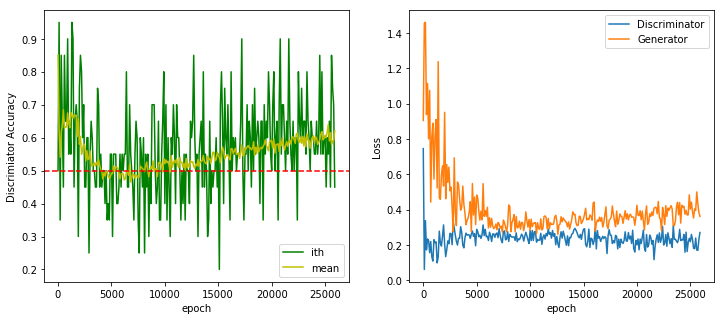

0 [D loss: 0.604040, acc.: 50.00%] [G loss: 0.603090]
2000 [D loss: 0.233400, acc.: 60.00%] [G loss: 0.670072]
4000 [D loss: 0.236180, acc.: 55.00%] [G loss: 0.408164]
6000 [D loss: 0.276806, acc.: 60.00%] [G loss: 0.410731]
8000 [D loss: 0.259038, acc.: 45.00%] [G loss: 0.366111]
10000 [D loss: 0.204231, acc.: 85.00%] [G loss: 0.429074]
12000 [D loss: 0.239176, acc.: 45.00%] [G loss: 0.337895]
14000 [D loss: 0.265173, acc.: 50.00%] [G loss: 0.437931]
16000 [D loss: 0.193774, acc.: 70.00%] [G loss: 0.312261]
18000 [D loss: 0.169807, acc.: 65.00%] [G loss: 0.368537]
20000 [D loss: 0.218998, acc.: 70.00%] [G loss: 0.368293]
22000 [D loss: 0.294331, acc.: 35.00%] [G loss: 0.325765]
24000 [D loss: 0.244337, acc.: 60.00%] [G loss: 0.393997]
26000 [D loss: 0.211164, acc.: 65.00%] [G loss: 0.310278]
28000 [D loss: 0.211393, acc.: 60.00%] [G loss: 0.384785]
30000 [D loss: 0.141789, acc.: 85.00%] [G loss: 0.570626]


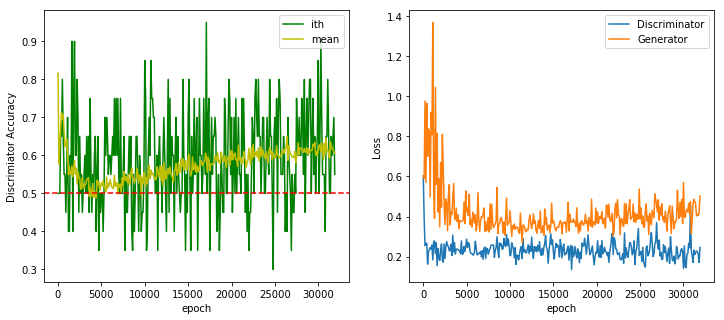

0 [D loss: 0.681665, acc.: 50.00%] [G loss: 1.217773]
2000 [D loss: 0.197434, acc.: 60.00%] [G loss: 0.915464]
4000 [D loss: 0.285784, acc.: 40.00%] [G loss: 0.409203]
6000 [D loss: 0.239683, acc.: 55.00%] [G loss: 0.369409]


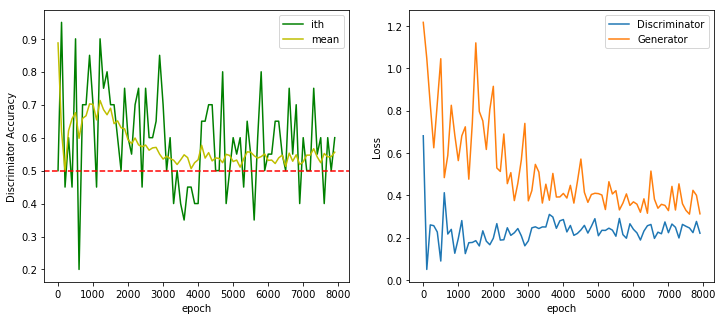

0 [D loss: 0.481394, acc.: 50.00%] [G loss: 0.898101]
2000 [D loss: 0.195689, acc.: 65.00%] [G loss: 0.695317]
4000 [D loss: 0.220025, acc.: 55.00%] [G loss: 0.399057]
6000 [D loss: 0.211691, acc.: 60.00%] [G loss: 0.332982]
8000 [D loss: 0.204616, acc.: 55.00%] [G loss: 0.395717]
10000 [D loss: 0.221103, acc.: 65.00%] [G loss: 0.385895]
12000 [D loss: 0.252522, acc.: 45.00%] [G loss: 0.298459]


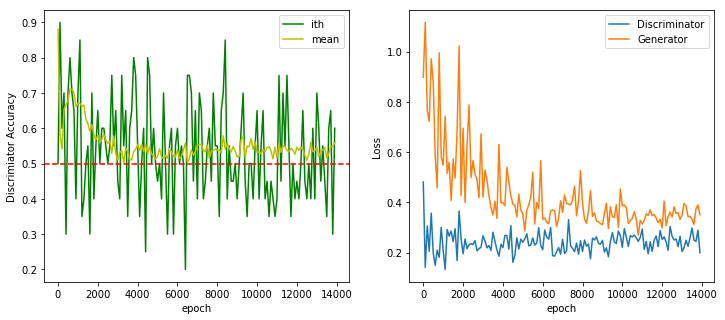

0 [D loss: 0.647870, acc.: 50.00%] [G loss: 1.297511]
2000 [D loss: 0.211927, acc.: 70.00%] [G loss: 0.546197]
4000 [D loss: 0.194139, acc.: 75.00%] [G loss: 0.587900]
6000 [D loss: 0.226260, acc.: 65.00%] [G loss: 0.346097]
8000 [D loss: 0.224548, acc.: 60.00%] [G loss: 0.379867]
10000 [D loss: 0.252892, acc.: 45.00%] [G loss: 0.352804]
12000 [D loss: 0.258700, acc.: 45.00%] [G loss: 0.353142]
14000 [D loss: 0.255054, acc.: 50.00%] [G loss: 0.407125]
16000 [D loss: 0.237974, acc.: 65.00%] [G loss: 0.404710]
18000 [D loss: 0.193665, acc.: 70.00%] [G loss: 0.367202]


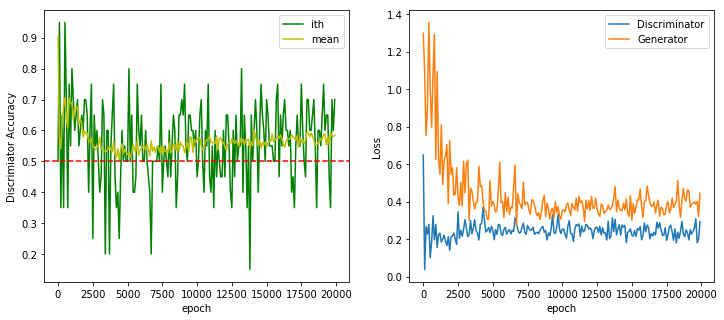

0 [D loss: 0.782963, acc.: 50.00%] [G loss: 1.024218]
2000 [D loss: 0.169643, acc.: 75.00%] [G loss: 0.429381]
4000 [D loss: 0.271978, acc.: 30.00%] [G loss: 0.336882]
6000 [D loss: 0.241729, acc.: 45.00%] [G loss: 0.373295]
8000 [D loss: 0.230550, acc.: 70.00%] [G loss: 0.361089]
10000 [D loss: 0.239238, acc.: 40.00%] [G loss: 0.382377]
12000 [D loss: 0.176132, acc.: 75.00%] [G loss: 0.341685]
14000 [D loss: 0.219851, acc.: 60.00%] [G loss: 0.362101]
16000 [D loss: 0.228016, acc.: 50.00%] [G loss: 0.356135]
18000 [D loss: 0.167068, acc.: 80.00%] [G loss: 0.435550]
20000 [D loss: 0.297407, acc.: 55.00%] [G loss: 0.415278]
22000 [D loss: 0.252250, acc.: 45.00%] [G loss: 0.395380]
24000 [D loss: 0.276382, acc.: 60.00%] [G loss: 0.370004]


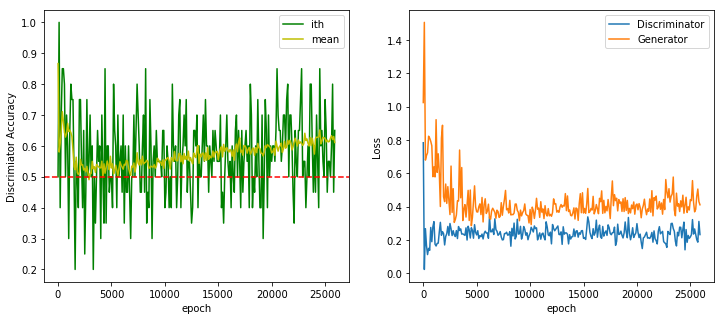

0 [D loss: 1.690666, acc.: 50.00%] [G loss: 0.675606]
2000 [D loss: 0.228538, acc.: 60.00%] [G loss: 0.607441]
4000 [D loss: 0.207175, acc.: 50.00%] [G loss: 0.354365]
6000 [D loss: 0.236869, acc.: 55.00%] [G loss: 0.548394]
8000 [D loss: 0.259655, acc.: 45.00%] [G loss: 0.426377]
10000 [D loss: 0.274139, acc.: 45.00%] [G loss: 0.310568]
12000 [D loss: 0.273936, acc.: 40.00%] [G loss: 0.394523]
14000 [D loss: 0.185178, acc.: 80.00%] [G loss: 0.406923]
16000 [D loss: 0.277974, acc.: 45.00%] [G loss: 0.439337]
18000 [D loss: 0.194199, acc.: 80.00%] [G loss: 0.360495]
20000 [D loss: 0.231264, acc.: 50.00%] [G loss: 0.441501]
22000 [D loss: 0.264178, acc.: 40.00%] [G loss: 0.311709]
24000 [D loss: 0.233211, acc.: 55.00%] [G loss: 0.378935]
26000 [D loss: 0.280436, acc.: 40.00%] [G loss: 0.422095]
28000 [D loss: 0.220083, acc.: 80.00%] [G loss: 0.511913]
30000 [D loss: 0.237862, acc.: 65.00%] [G loss: 0.415119]


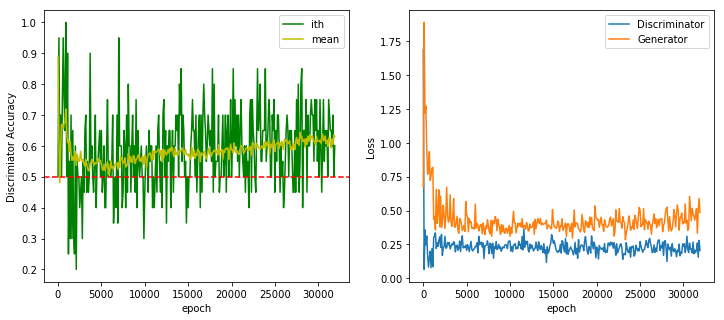

0 [D loss: 0.527721, acc.: 50.00%] [G loss: 0.951632]
2000 [D loss: 0.231380, acc.: 55.00%] [G loss: 0.633261]
4000 [D loss: 0.242049, acc.: 40.00%] [G loss: 0.420021]
6000 [D loss: 0.260556, acc.: 45.00%] [G loss: 0.336821]


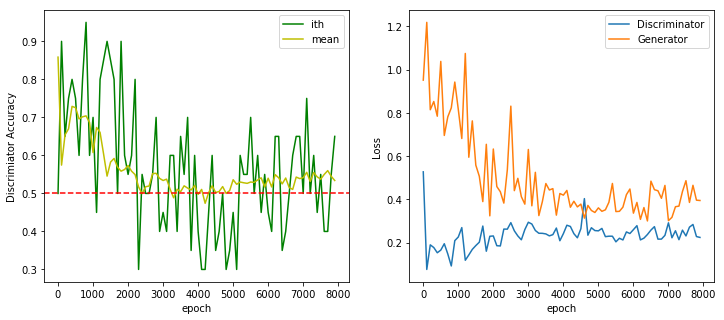

0 [D loss: 0.755310, acc.: 50.00%] [G loss: 0.753579]
2000 [D loss: 0.191773, acc.: 65.00%] [G loss: 0.392608]
4000 [D loss: 0.191789, acc.: 55.00%] [G loss: 0.464198]
6000 [D loss: 0.239015, acc.: 60.00%] [G loss: 0.420813]
8000 [D loss: 0.252968, acc.: 40.00%] [G loss: 0.406063]
10000 [D loss: 0.231158, acc.: 60.00%] [G loss: 0.332200]
12000 [D loss: 0.238592, acc.: 55.00%] [G loss: 0.323130]


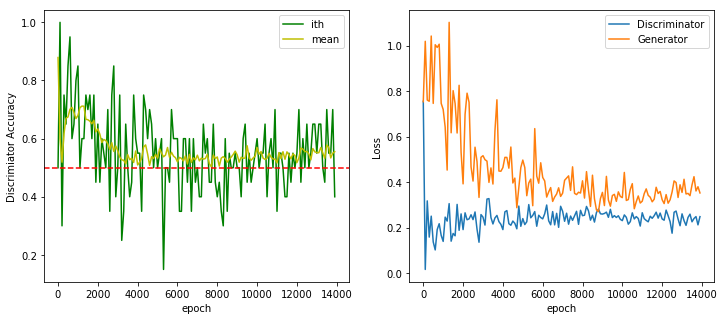

0 [D loss: 0.493635, acc.: 50.00%] [G loss: 0.583364]
2000 [D loss: 0.196987, acc.: 70.00%] [G loss: 0.751603]
4000 [D loss: 0.257816, acc.: 40.00%] [G loss: 0.345210]
6000 [D loss: 0.245762, acc.: 50.00%] [G loss: 0.444033]
8000 [D loss: 0.205459, acc.: 65.00%] [G loss: 0.323889]
10000 [D loss: 0.251008, acc.: 55.00%] [G loss: 0.489842]
12000 [D loss: 0.163035, acc.: 80.00%] [G loss: 0.386127]
14000 [D loss: 0.160995, acc.: 70.00%] [G loss: 0.372869]
16000 [D loss: 0.214291, acc.: 70.00%] [G loss: 0.395773]
18000 [D loss: 0.245077, acc.: 50.00%] [G loss: 0.357972]


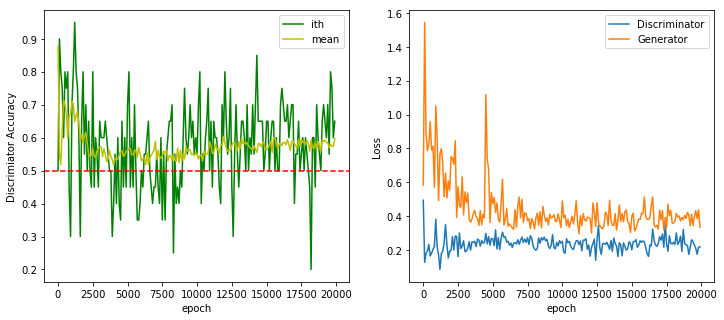

0 [D loss: 0.631752, acc.: 50.00%] [G loss: 1.090756]
2000 [D loss: 0.254172, acc.: 50.00%] [G loss: 0.450870]
4000 [D loss: 0.232087, acc.: 55.00%] [G loss: 0.442583]
6000 [D loss: 0.257512, acc.: 50.00%] [G loss: 0.314686]
8000 [D loss: 0.273787, acc.: 50.00%] [G loss: 0.347535]
10000 [D loss: 0.218228, acc.: 60.00%] [G loss: 0.365328]
12000 [D loss: 0.224297, acc.: 50.00%] [G loss: 0.428387]
14000 [D loss: 0.259556, acc.: 45.00%] [G loss: 0.365250]
16000 [D loss: 0.225889, acc.: 40.00%] [G loss: 0.381035]
18000 [D loss: 0.234799, acc.: 65.00%] [G loss: 0.462205]
20000 [D loss: 0.217216, acc.: 60.00%] [G loss: 0.358281]
22000 [D loss: 0.232086, acc.: 55.00%] [G loss: 0.377481]
24000 [D loss: 0.219469, acc.: 65.00%] [G loss: 0.556479]


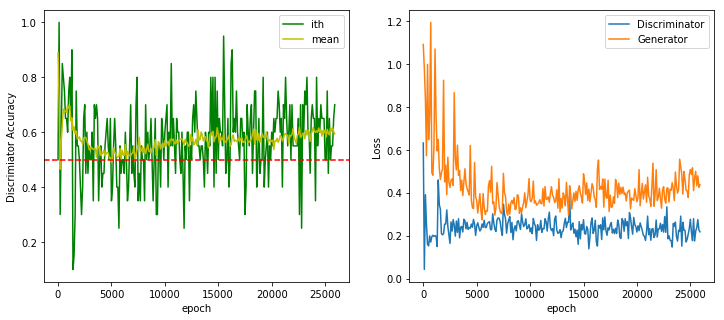

0 [D loss: 0.417312, acc.: 50.00%] [G loss: 1.019395]
2000 [D loss: 0.221904, acc.: 60.00%] [G loss: 0.503551]
4000 [D loss: 0.216652, acc.: 60.00%] [G loss: 0.595924]
6000 [D loss: 0.263785, acc.: 40.00%] [G loss: 0.408831]
8000 [D loss: 0.238790, acc.: 60.00%] [G loss: 0.309804]
10000 [D loss: 0.230558, acc.: 70.00%] [G loss: 0.321783]
12000 [D loss: 0.302374, acc.: 30.00%] [G loss: 0.342158]
14000 [D loss: 0.237273, acc.: 50.00%] [G loss: 0.324891]
16000 [D loss: 0.214314, acc.: 65.00%] [G loss: 0.391400]
18000 [D loss: 0.221683, acc.: 55.00%] [G loss: 0.324362]
20000 [D loss: 0.211323, acc.: 60.00%] [G loss: 0.385495]
22000 [D loss: 0.259935, acc.: 55.00%] [G loss: 0.389763]
24000 [D loss: 0.227461, acc.: 60.00%] [G loss: 0.342672]
26000 [D loss: 0.252273, acc.: 40.00%] [G loss: 0.405220]
28000 [D loss: 0.217660, acc.: 60.00%] [G loss: 0.497540]
30000 [D loss: 0.199369, acc.: 70.00%] [G loss: 0.364298]


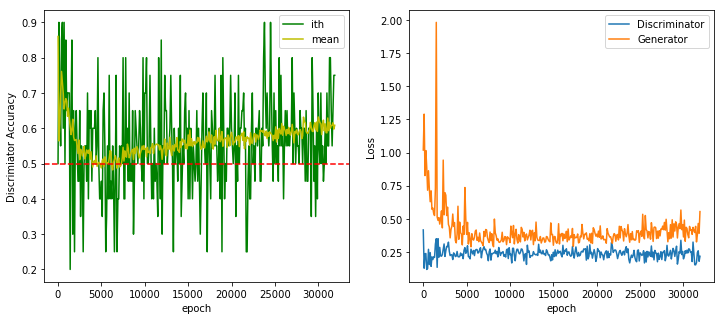

In [83]:
epochs = [8000, 14000, 20000, 26000, 32000]
dist_trains = []
dist_tests = []

# Train-test split:
X_real = ssEDCs.copy()

for k in range(4):
    X_train, X_test = train_test_split(X_real, test_size=0.25, shuffle=True)
    dist_trains_e = []
    dist_tests_e = []

    # Do PCA:
    pca = PCA(n_components=3)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    X_fake_pcas = []

    for e in epochs:
        # Train GAN
        gan = LSGAN('adadelta', 'mse', False)   
        gan.train(X_train, epochs=e, batch_size=20, sample_interval=500)
        plotGANprocess(gan, 100)

        # Create fake data:
        fake_data = gan.create_fake_data(X_test.shape[0])

        # Do PCA:
        X_fake_pca = pca.transform(fake_data)
        X_fake_pcas.append(X_fake_pca)

        # Measure distance:
        nearest_dist_train, nearest_dist_test = train_test_fake_distance(X_train_pca, X_test_pca, X_fake_pca)
        dist_trains_e.append(nearest_dist_train)
        dist_tests_e.append(nearest_dist_test)
        
        # Display result:
        # show_dist_distribution(nearest_dist_train, nearest_dist_test)
    
    dist_trains.append(np.array(dist_trains_e))
    dist_tests.append(np.array(dist_tests_e))

Train: mean=1.544372564907687, std=1.0294666977115532
Test: mean=1.346118268192259, std=0.9674237874246713


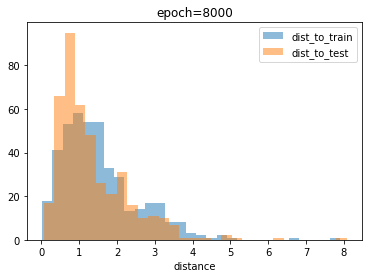

Train: mean=1.7112361536734901, std=1.3416811833227622
Test: mean=1.4674861317872556, std=1.240107516072218


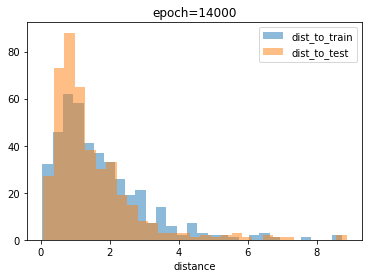

Train: mean=1.5015597348075596, std=1.2710904331175203
Test: mean=1.3942690946265193, std=1.2485224408163926


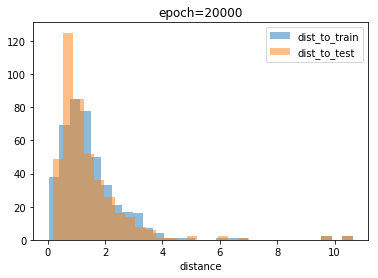

Train: mean=1.5420780152787976, std=1.3055787137171857
Test: mean=1.3699112982865764, std=1.2519223311392595


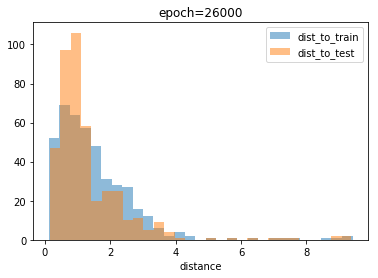

Train: mean=1.566295124412564, std=1.260793610329067
Test: mean=1.3134427585759618, std=1.2256860251660888


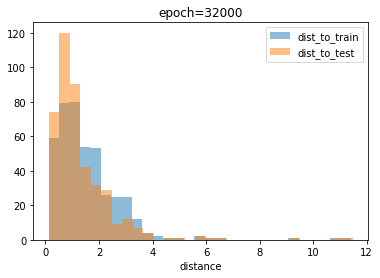

In [101]:
for e in range(5):
    dist_tr = np.array([dist_trains[i][e] for i in range(len(dist_trains))]).flatten()
    dist_te = np.array([dist_tests[i][e] for i in range(len(dist_tests))]).flatten()
    show_dist_distribution(dist_tr, dist_te, "epoch="+str(epochs[e]))

#### Discussion:
These results are counter intuitive. It seems that the mean nearest distance between synthetic data and training data is larger than that between the synthetic data and the testing data. However, if we take a step back and look at the dispersion of data in the reduced space, we can find a reasonable explanation. The data are not distributed uniformly in the subspace but have a weird shape for most of the data as a whole and some outliers. These outliers, as it is shown in the main text, are part of the real data, therefore we expect the generator to also generate some data like this. However, with limited genuine data, it is hard to ensure the same distribution of the training and testing data. Namely, it is hard to gaurantee that there is same proportion of data from the main group and outliers asigned to the training and testing subset. 

C:\Users\Elite840G2\Anaconda3\envs\ds100\lib\site-packages\keras\engine\training.py:973: UserWarning:

Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?



0 [D loss: 0.982862, acc.: 50.00%] [G loss: 1.710226]
2000 [D loss: 0.173695, acc.: 70.00%] [G loss: 0.871283]
4000 [D loss: 0.275684, acc.: 40.00%] [G loss: 0.365410]
6000 [D loss: 0.214981, acc.: 60.00%] [G loss: 0.440253]
8000 [D loss: 0.239321, acc.: 45.00%] [G loss: 0.403779]
10000 [D loss: 0.247060, acc.: 55.00%] [G loss: 0.354311]
12000 [D loss: 0.272246, acc.: 40.00%] [G loss: 0.363832]
14000 [D loss: 0.271253, acc.: 50.00%] [G loss: 0.416503]


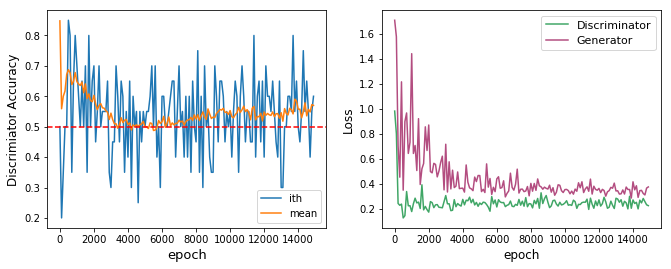

0 [D loss: 0.733431, acc.: 50.00%] [G loss: 0.801475]
2000 [D loss: 0.258602, acc.: 55.00%] [G loss: 0.741719]
4000 [D loss: 0.250618, acc.: 60.00%] [G loss: 0.461531]
6000 [D loss: 0.277391, acc.: 50.00%] [G loss: 0.394142]
8000 [D loss: 0.229281, acc.: 65.00%] [G loss: 0.323423]
10000 [D loss: 0.244186, acc.: 55.00%] [G loss: 0.405630]
12000 [D loss: 0.240447, acc.: 50.00%] [G loss: 0.343766]
14000 [D loss: 0.248673, acc.: 60.00%] [G loss: 0.392951]
0 [D loss: 0.270075, acc.: 50.00%] [G loss: 0.834895]
2000 [D loss: 0.224132, acc.: 50.00%] [G loss: 0.368074]
4000 [D loss: 0.234509, acc.: 50.00%] [G loss: 0.398366]
6000 [D loss: 0.261835, acc.: 50.00%] [G loss: 0.350352]
8000 [D loss: 0.257668, acc.: 45.00%] [G loss: 0.340190]
10000 [D loss: 0.231821, acc.: 50.00%] [G loss: 0.358435]
12000 [D loss: 0.248105, acc.: 50.00%] [G loss: 0.337129]
14000 [D loss: 0.255813, acc.: 45.00%] [G loss: 0.354840]
0 [D loss: 0.927581, acc.: 50.00%] [G loss: 1.047074]
2000 [D loss: 0.186802, acc.: 60.0

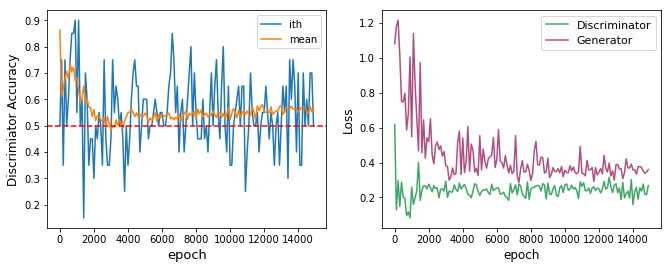

0 [D loss: 0.311595, acc.: 50.00%] [G loss: 0.929500]
2000 [D loss: 0.245908, acc.: 50.00%] [G loss: 0.486649]
4000 [D loss: 0.273484, acc.: 30.00%] [G loss: 0.376470]
6000 [D loss: 0.301704, acc.: 25.00%] [G loss: 0.290225]
8000 [D loss: 0.263517, acc.: 45.00%] [G loss: 0.364469]
10000 [D loss: 0.232584, acc.: 65.00%] [G loss: 0.355355]
12000 [D loss: 0.189108, acc.: 75.00%] [G loss: 0.333423]
14000 [D loss: 0.275997, acc.: 45.00%] [G loss: 0.337859]
0 [D loss: 0.515283, acc.: 50.00%] [G loss: 1.140307]
2000 [D loss: 0.210561, acc.: 70.00%] [G loss: 0.544824]
4000 [D loss: 0.247334, acc.: 45.00%] [G loss: 0.526728]
6000 [D loss: 0.235643, acc.: 60.00%] [G loss: 0.389945]
8000 [D loss: 0.248935, acc.: 40.00%] [G loss: 0.308931]
10000 [D loss: 0.223848, acc.: 75.00%] [G loss: 0.337190]
12000 [D loss: 0.251475, acc.: 50.00%] [G loss: 0.368050]
14000 [D loss: 0.277827, acc.: 40.00%] [G loss: 0.359190]
0 [D loss: 0.512209, acc.: 50.00%] [G loss: 1.841210]
2000 [D loss: 0.255660, acc.: 55.0

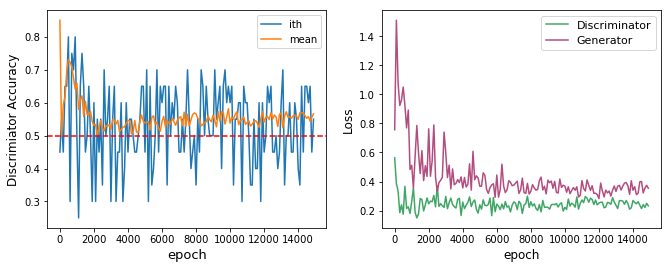

0 [D loss: 0.191970, acc.: 50.00%] [G loss: 0.603166]
2000 [D loss: 0.192384, acc.: 65.00%] [G loss: 0.529608]
4000 [D loss: 0.274282, acc.: 45.00%] [G loss: 0.397349]
6000 [D loss: 0.214993, acc.: 60.00%] [G loss: 0.473012]
8000 [D loss: 0.219231, acc.: 60.00%] [G loss: 0.357270]
10000 [D loss: 0.234313, acc.: 60.00%] [G loss: 0.363820]
12000 [D loss: 0.281709, acc.: 45.00%] [G loss: 0.434335]
14000 [D loss: 0.255191, acc.: 45.00%] [G loss: 0.358895]
0 [D loss: 0.507405, acc.: 50.00%] [G loss: 1.445306]
2000 [D loss: 0.264412, acc.: 50.00%] [G loss: 0.446633]
4000 [D loss: 0.298526, acc.: 25.00%] [G loss: 0.582482]
6000 [D loss: 0.213130, acc.: 60.00%] [G loss: 0.405588]
8000 [D loss: 0.234673, acc.: 65.00%] [G loss: 0.324918]
10000 [D loss: 0.223899, acc.: 65.00%] [G loss: 0.357017]
12000 [D loss: 0.230753, acc.: 60.00%] [G loss: 0.313832]
14000 [D loss: 0.206969, acc.: 65.00%] [G loss: 0.331155]
0 [D loss: 0.509086, acc.: 50.00%] [G loss: 0.850310]
2000 [D loss: 0.213383, acc.: 60.0

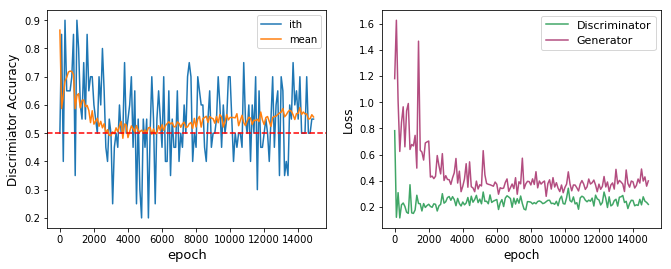

0 [D loss: 0.464550, acc.: 50.00%] [G loss: 0.971877]
2000 [D loss: 0.206979, acc.: 65.00%] [G loss: 0.649909]
4000 [D loss: 0.255150, acc.: 65.00%] [G loss: 0.346993]
6000 [D loss: 0.214908, acc.: 65.00%] [G loss: 0.322114]
8000 [D loss: 0.225589, acc.: 65.00%] [G loss: 0.372698]
10000 [D loss: 0.228344, acc.: 55.00%] [G loss: 0.376241]
12000 [D loss: 0.237370, acc.: 60.00%] [G loss: 0.383932]
14000 [D loss: 0.200883, acc.: 70.00%] [G loss: 0.408402]
0 [D loss: 0.343724, acc.: 55.00%] [G loss: 0.628861]
2000 [D loss: 0.144929, acc.: 75.00%] [G loss: 0.574490]
4000 [D loss: 0.265223, acc.: 40.00%] [G loss: 0.516938]
6000 [D loss: 0.241688, acc.: 50.00%] [G loss: 0.455441]
8000 [D loss: 0.253569, acc.: 50.00%] [G loss: 0.311908]
10000 [D loss: 0.223670, acc.: 65.00%] [G loss: 0.310412]
12000 [D loss: 0.210530, acc.: 60.00%] [G loss: 0.350826]
14000 [D loss: 0.249860, acc.: 50.00%] [G loss: 0.314296]
0 [D loss: 0.477515, acc.: 50.00%] [G loss: 0.733207]
2000 [D loss: 0.244038, acc.: 60.0

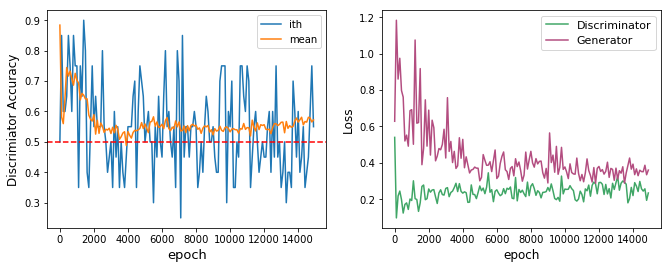

0 [D loss: 0.414429, acc.: 50.00%] [G loss: 0.491967]
2000 [D loss: 0.343934, acc.: 55.00%] [G loss: 0.448949]
4000 [D loss: 0.229505, acc.: 50.00%] [G loss: 0.480178]
6000 [D loss: 0.213801, acc.: 55.00%] [G loss: 0.467755]
8000 [D loss: 0.256875, acc.: 45.00%] [G loss: 0.395346]
10000 [D loss: 0.248894, acc.: 50.00%] [G loss: 0.351433]
12000 [D loss: 0.322843, acc.: 40.00%] [G loss: 0.361072]
14000 [D loss: 0.204170, acc.: 60.00%] [G loss: 0.390187]
0 [D loss: 0.212621, acc.: 55.00%] [G loss: 0.719577]
2000 [D loss: 0.256825, acc.: 45.00%] [G loss: 0.565074]
4000 [D loss: 0.206385, acc.: 55.00%] [G loss: 0.388790]
6000 [D loss: 0.241310, acc.: 60.00%] [G loss: 0.390344]
8000 [D loss: 0.280544, acc.: 45.00%] [G loss: 0.390411]
10000 [D loss: 0.206092, acc.: 60.00%] [G loss: 0.364156]
12000 [D loss: 0.250727, acc.: 55.00%] [G loss: 0.345645]
14000 [D loss: 0.226439, acc.: 60.00%] [G loss: 0.431639]
0 [D loss: 0.878274, acc.: 50.00%] [G loss: 0.842034]
2000 [D loss: 0.218759, acc.: 60.0

In [151]:
e = 15000
dist_trains = []
dist_tests = []

# Train-test split:
X_real = ssEDCs.copy()

for k in range(20):
    X_train, X_test = train_test_split(X_real, test_size=0.25, shuffle=True)

    # Do PCA:
    pca = PCA(n_components=3)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    X_fake_pcas = []

    gan = LSGAN('adadelta', 'mse', False)   
    gan.train(X_train, epochs=e, batch_size=20, sample_interval=500)
    if k % 4 == 0:
        plotGANprocess(gan, 100)

    # Create fake data:
    fake_data = gan.create_fake_data(X_test.shape[0])

    # Do PCA:
    X_fake_pca = pca.transform(fake_data)
    X_fake_pcas.append(X_fake_pca)

    # Measure distance:
    nearest_dist_train, nearest_dist_test = train_test_fake_distance(X_train_pca, X_test_pca, X_fake_pca)
    dist_trains.append(nearest_dist_train)
    dist_tests.append(nearest_dist_test)
        
    # Display result:
    # show_dist_distribution(nearest_dist_train, nearest_dist_test)

In [155]:
dist_trains_1D = np.array(dist_trains).flatten()
dist_tests_1D = np.array(dist_tests).flatten()

Train: mean=1.5970703695908275, std=1.3158208141575154
Test: mean=1.6525065772675207, std=1.3137626015551247


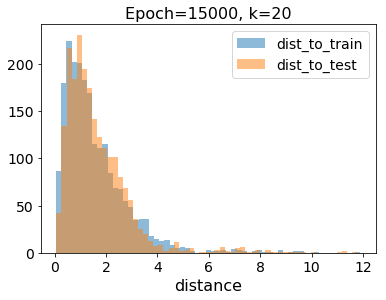

In [172]:
show_dist_distribution(dist_trains_1D, dist_tests_1D, 'Epoch=15000, k=20', 60)